In [1]:
import pymongo
import pandas as pd
from SETTINGS import name_source_database, name_image_file_lookup
import matplotlib.pyplot as plt
import seaborn as sns
import os
%matplotlib inline

In [2]:
connection = pymongo.MongoClient()
db = connection[name_source_database]
similarity_collection = db['file_similarity']
file_lookup_collection = db[name_image_file_lookup]

# Sampling to check image similarity
Skip if already done

In [3]:
scores_pipeline = [{'$match':{'rank_score':{'$exists':1}}}]
scores_cursor = similarity_collection.aggregate(pipeline=scores_pipeline, allowDiskUse=True)

rank_scores = pd.DataFrame(scores_cursor, columns=['_id','rank_score','hash_score','avg_score'])

In [4]:
rank_scores['a'] = rank_scores._id.apply(lambda x: x.split('_')[0])
rank_scores['b'] = rank_scores._id.apply(lambda x: x.split('_')[1])
rank_scores.drop(columns=['_id'], inplace=True)
# temp_rank_scores['rank_score'].replace(to_replace=2, value=0, inplace=True)

In [5]:
rank_scores.head()

,rank_score,hash_score,avg_score,a,b
0,0.094228,0.31,0.202114,00000.jpg,00001.jpg
1,0.267207,0.25,0.258603,00000.jpg,00002.jpg
2,0.197351,0.38,0.288675,00000.jpg,00004.jpg
3,0.135194,0.25,0.192597,00000.jpg,00005.jpg
4,0.352083,0.44,0.396042,00000.jpg,00006.jpg


In [6]:
file_lookup_pipeline = [{'$match':{'filename':{'$exists':1}}}, {'$project':{'hash':1, 'filename':1}}]
file_lookup_cursor = file_lookup_collection.aggregate(pipeline=file_lookup_pipeline, allowDiskUse=True)
file_lookup_df = pd.DataFrame(file_lookup_cursor)

In [7]:
file_lookup_df.head()

,_id,filename,hash
0,http://pbs.twimg.com/media/BYPJ4QTCEAArCA7.jpg,00000.jpg,94985474d0f0b2f2
1,http://pbs.twimg.com/media/C-ZZ2hsW0AAGJ4y.jpg,00001.jpg,f0ac7c3c3250b2b2
2,http://pbs.twimg.com/media/C-Zb4ZqW0AARyIy.jpg,00002.jpg,156b665773ebfcde
3,http://pbs.twimg.com/media/C1VnGaUXgAA3DGK.jpg,00003.jpg,5f5b335373734686
4,http://pbs.twimg.com/media/C3HKX9JXgAAoyJe.jpg,01046.jpg,557525656565059b


In [8]:
rank_scores = rank_scores.merge(file_lookup_df[['filename','hash']], left_on='a', right_on='filename', how='left').rename(columns={'hash':'a_hash'}).drop(columns=['filename'])
rank_scores = rank_scores.merge(file_lookup_df[['filename','hash']], left_on='b', right_on='filename', how='left').rename(columns={'hash':'b_hash'}).drop(columns=['filename'])



In [9]:
rank_scores.head()

,rank_score,hash_score,avg_score,a,b,a_hash,b_hash
0,0.094228,0.31,0.202114,00000.jpg,00001.jpg,94985474d0f0b2f2,f0ac7c3c3250b2b2
1,0.267207,0.25,0.258603,00000.jpg,00002.jpg,94985474d0f0b2f2,156b665773ebfcde
2,0.197351,0.38,0.288675,00000.jpg,00004.jpg,94985474d0f0b2f2,cd4d0b0b4f470f3f
3,0.135194,0.25,0.192597,00000.jpg,00005.jpg,94985474d0f0b2f2,2f377973333229a5
4,0.352083,0.44,0.396042,00000.jpg,00006.jpg,94985474d0f0b2f2,4e8c51470b333b13


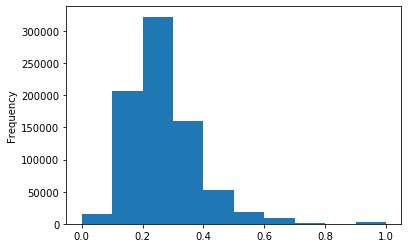

In [10]:
rank_scores.avg_score.plot(kind='hist')

In [11]:
rank_scores['difference'] = abs(rank_scores['hash_score'] - rank_scores['rank_score'])

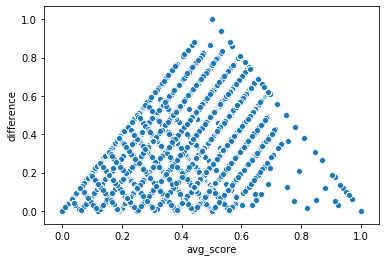

In [12]:
sns.scatterplot(data=rank_scores, x='avg_score', y='difference')

In [13]:
rank_scores['factor_diff'] = 1 - (rank_scores['avg_score'] * rank_scores['difference'])

### Sampling and checking files
In this section we sample 5 images between a range of average scores. We then look them up in the image files, and make a decision as to whether these images are the same or not. We do this for multiple bands and then examine the results.

In [15]:
sample_index = rank_scores[(rank_scores.avg_score < 1.05) & (rank_scores.avg_score >= 1)].sample(5, replace=False).index

In [16]:
rank_scores.loc[sample_index]

,rank_score,hash_score,avg_score,a,b,a_hash,b_hash,difference,factor_diff
126155,1.0,1.0,1.0,00111.jpg,00191.jpg,d8d861a9c8d8cce4,d8d861a9c8d8cce4,0.0,1.0
110670,1.0,1.0,1.0,00097.jpg,00177.jpg,d8d861a9c8d8cce4,d8d861a9c8d8cce4,0.0,1.0
747607,1.0,1.0,1.0,01257.jpg,01130.jpg,38383123c14160f0,38383123c14160f0,0.0,1.0
113944,1.0,1.0,1.0,00100.jpg,00117.jpg,d8d861a9c8d8cce4,d8d861a9c8d8cce4,0.0,1.0
210437,1.0,1.0,1.0,00192.jpg,00211.jpg,d8d861a9c8d8cce4,d8d861a9c8d8cce4,0.0,1.0


In [141]:
decisions = [True,True,True, True,True]
rank_scores.loc[sample_index,'image_same'] = decisions

In [17]:
rank_scores.to_pickle('rank_scores_with_sampling.pkl')
rank_scores.to_csv('rank_scores_with_sampling.csv')

# Examining Scoring

In [17]:
rank_scores = pd.read_pickle('rank_scores_with_sampling.pkl')

In [19]:
rank_scores

,rank_score,hash_score,avg_score,a,b,a_hash,b_hash,difference,factor_diff
0,0.094228,0.31,0.202114,00000.jpg,00001.jpg,94985474d0f0b2f2,f0ac7c3c3250b2b2,0.215772,0.956389
1,0.267207,0.25,0.258603,00000.jpg,00002.jpg,94985474d0f0b2f2,156b665773ebfcde,0.017207,0.995550
2,0.337368,0.19,0.263684,00001.jpg,00002.jpg,f0ac7c3c3250b2b2,156b665773ebfcde,0.147368,0.961142
3,0.197351,0.38,0.288675,00000.jpg,00004.jpg,94985474d0f0b2f2,cd4d0b0b4f470f3f,0.182649,0.947274
4,0.372578,0.25,0.311289,00001.jpg,00004.jpg,f0ac7c3c3250b2b2,cd4d0b0b4f470f3f,0.122578,0.961843
5,0.207316,0.25,0.228658,00002.jpg,00004.jpg,156b665773ebfcde,cd4d0b0b4f470f3f,0.042684,0.990240
6,0.135194,0.25,0.192597,00000.jpg,00005.jpg,94985474d0f0b2f2,2f377973333229a5,0.114806,0.977889
7,0.183222,0.38,0.281611,00001.jpg,00005.jpg,f0ac7c3c3250b2b2,2f377973333229a5,0.196778,0.944585
8,0.058859,0.19,0.124430,00002.jpg,00005.jpg,156b665773ebfcde,2f377973333229a5,0.131141,0.983682
9,0.178511,0.19,0.184256,00004.jpg,00005.jpg,cd4d0b0b4f470f3f,2f377973333229a5,0.011489,0.997883


In [18]:
rank_scores[~rank_scores.image_same.isna()]['avg_score'].plot(kind='hist', bins=20)

AttributeError: 'DataFrame' object has no attribute 'image_same'

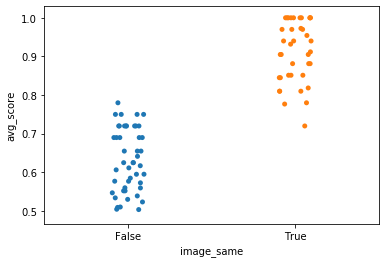

In [146]:
sns.stripplot(data=rank_scores[~rank_scores.image_same.isna()], x='image_same', y='avg_score')

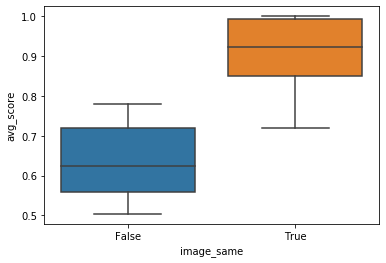

In [150]:
sns.boxplot(data=rank_scores[~rank_scores.image_same.isna()], x='image_same', y='avg_score')

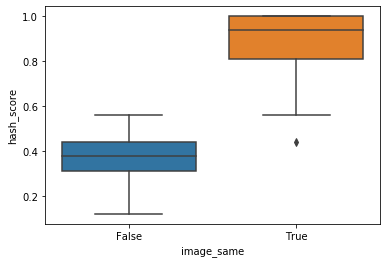

In [151]:
sns.boxplot(data=rank_scores[~rank_scores.image_same.isna()], x='image_same', y='hash_score')

In [154]:
rank_scores.groupby('image_same').max()

,rank_score,hash_score,avg_score,a,b,a_hash,b_hash,difference,factor_diff
image_same,,,,,,,,,
False,1.0,0.56,0.78,00776.jpg,01038.jpg,fcf97979f1f5567c,fbb7dcfba1edadd3,0.88,0.863624
True,1.0,1.00,1.00,00955.jpg,00961.jpg,e9b5b4e0b6b7cb4a,e9b5b4e0b6b7db4a,0.56,1.000000


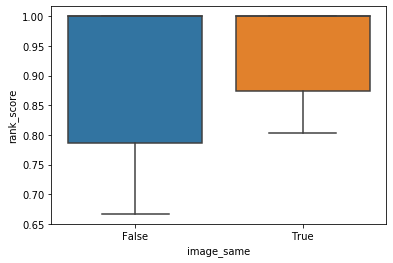

In [152]:
sns.boxplot(data=rank_scores[~rank_scores.image_same.isna()], x='image_same', y='rank_score')

In [171]:
agglom = rank_scores[rank_scores.hash_score >= 0.65].groupby(
    ['a']).agg(
    {'a': list,'b':list})

In [172]:
agglom.head()

,a,b
a,,
00004.jpg,[00004.jpg],[00015.jpg]
00010.jpg,[00010.jpg],[00011.jpg]
00019.jpg,"[00019.jpg, 00019.jpg]","[00020.jpg, 00068.jpg]"
00020.jpg,[00020.jpg],[00068.jpg]
00032.jpg,[00032.jpg],[00475.jpg]


In [181]:
def build_duplicate_lookup(rank_scores, threshold, group_on, collate_col, score_col='hash_score'):
    assigned = []
    agglom_dict = {}
    agglom = rank_scores[rank_scores[score_col] >= threshold].groupby(
    [group_on]).agg(
    {group_on: list,collate_col:list})
    for idx, row in agglom.iterrows():
        similars = row[collate_col]
        similars = list(set(similars) - set(assigned))
        if idx not in assigned:
            try:
                agglom_dict[idx].extend(similars)
            except KeyError:
                agglom_dict[idx] = similars
            assigned.extend(similars)

    final_dict = {}
    for k, v in agglom_dict.items():
        for item in v:
            final_dict[item] = k
    return final_dict

In [182]:
t = build_duplicate_lookup(rank_scores=rank_scores,
                          threshold=0.65,
                          group_on='a',
                          collate_col='b',
                          score_col='hash_score')

In [183]:
t

{'00015.jpg': '00004.jpg',
 '00011.jpg': '00010.jpg',
 '00020.jpg': '00019.jpg',
 '00068.jpg': '00019.jpg',
 '00475.jpg': '00032.jpg',
 '00038.png': '00037.png',
 '00058.png': '00037.png',
 '00043.jpg': '00042.jpg',
 '00045.jpg': '00044.jpg',
 '00050.jpg': '00044.jpg',
 '00079.png': '00046.jpg',
 '00078.png': '00046.jpg',
 '00077.png': '00046.jpg',
 '00053.jpg': '00047.jpg',
 '00054.jpg': '00047.jpg',
 '00056.jpg': '00055.jpg',
 '00163.jpg': '00070.jpg',
 '00202.jpg': '00070.jpg',
 '00172.jpg': '00070.jpg',
 '00125.jpg': '00070.jpg',
 '00123.jpg': '00070.jpg',
 '00148.jpg': '00070.jpg',
 '00212.jpg': '00070.jpg',
 '00170.jpg': '00070.jpg',
 '00100.jpg': '00070.jpg',
 '00131.jpg': '00070.jpg',
 '00111.jpg': '00070.jpg',
 '00161.jpg': '00070.jpg',
 '00107.jpg': '00070.jpg',
 '00190.jpg': '00070.jpg',
 '00195.jpg': '00070.jpg',
 '00130.jpg': '00070.jpg',
 '00181.jpg': '00070.jpg',
 '00211.jpg': '00070.jpg',
 '00124.jpg': '00070.jpg',
 '00158.jpg': '00070.jpg',
 '00166.jpg': '00070.jpg',
 

In [179]:
len(final_dict)

200

In [180]:
len(agglom_dict)

79